<a href="https://colab.research.google.com/github/sur-sakthy/computer-vision/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #2

In [1]:
!nvidia-smi

Tue Mar 21 22:48:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp '/content/drive/MyDrive/EE544 Computer Vision/Assignment/imagewoof2-320.tgz' ./

In [4]:
# remove %%capture command to show output from unzipping
%%capture
!tar zxvf /content/imagewoof2-320.tgz

## Imports

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, AveragePooling2D, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, AUC, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Constants

In [6]:
PATH_TO_TRAIN_DATA = '/content/imagewoof2-320/train'
PATH_TO_VAL_DATA = '/content/imagewoof2-320/val'

IMG_WIDTH=224
IMG_HEIGHT=224

NUM_CLASSES=3

In [7]:
all_classes = os.listdir(PATH_TO_TRAIN_DATA)
all_classes

['n02089973',
 'n02087394',
 'n02093754',
 'n02105641',
 'n02088364',
 'n02096294',
 'n02099601',
 'n02111889',
 'n02086240',
 'n02115641']

In [8]:
all_classes = os.listdir(PATH_TO_VAL_DATA)
all_classes

['n02089973',
 'n02087394',
 'n02093754',
 'n02105641',
 'n02088364',
 'n02096294',
 'n02099601',
 'n02111889',
 'n02086240',
 'n02115641']

## Load dataset

In [9]:
data = []
labels = []

In [10]:
def load_dataset(img_folder): 
    for dir in os.listdir(img_folder):
      if dir == 'n02105641' or dir == 'n02087394' or dir == 'n02096294':
        for file in os.listdir(os.path.join(img_folder, dir)):
       
            image_path = os.path.join(img_folder, dir, file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            image = np.array(image)

            data.append(image)
            labels.append(dir)

In [11]:
load_dataset(PATH_TO_TRAIN_DATA)
load_dataset(PATH_TO_VAL_DATA)

In [12]:
np.unique(labels)

array(['n02087394', 'n02096294', 'n02105641'], dtype='<U9')

In [13]:
data[0]

array([[[22,  6,  6],
        [22,  7,  4],
        [22,  7,  4],
        ...,
        [22,  7,  4],
        [22,  7,  4],
        [22,  7,  4]],

       [[22,  6,  6],
        [22,  7,  4],
        [22,  7,  4],
        ...,
        [22,  7,  4],
        [22,  7,  4],
        [22,  7,  4]],

       [[22,  7,  4],
        [22,  7,  4],
        [22,  7,  4],
        ...,
        [22,  7,  4],
        [22,  7,  4],
        [22,  7,  4]],

       ...,

       [[22,  7,  4],
        [22,  7,  4],
        [21,  7,  4],
        ...,
        [22,  7,  4],
        [22,  7,  4],
        [22,  7,  4]],

       [[22,  6,  6],
        [22,  7,  4],
        [21,  7,  4],
        ...,
        [22,  7,  4],
        [22,  7,  4],
        [22,  7,  4]],

       [[22,  6,  6],
        [22,  7,  4],
        [21,  7,  4],
        ...,
        [22,  7,  4],
        [22,  7,  4],
        [22,  7,  4]]], dtype=uint8)

In [14]:
np.min(data), np.max(data)

(0, 255)

## Split dataset
Experimenting with the following splits:

Training/Validation/Test:
- 80/10/10
- 60/30/10
- 70/20/10


In [15]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.40, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=42)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Class distribution

In [18]:
df_train = pd.DataFrame(y_train, columns=['label'])
df_train.head()

,label
0,n02096294
1,n02105641
2,n02096294
3,n02105641
4,n02105641


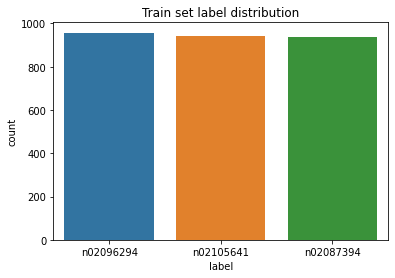

In [19]:
sns.countplot(data=df_train, x='label')
plt.title('Train set label distribution') 
plt.show()

In [20]:
df_test = pd.DataFrame(y_test, columns=['label'])
df_test.head()

,label
0,n02087394
1,n02087394
2,n02096294
3,n02087394
4,n02096294


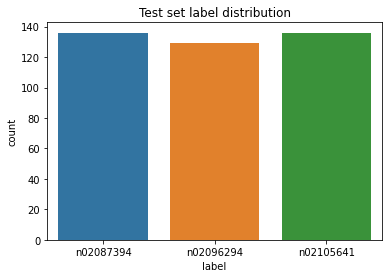

In [21]:
sns.countplot(data=df_test, x='label')
plt.title('Test set label distribution') 
plt.show()

In [22]:
df_val = pd.DataFrame(y_val, columns=['label'])
df_val.head()

,label
0,n02105641
1,n02096294
2,n02087394
3,n02087394
4,n02105641


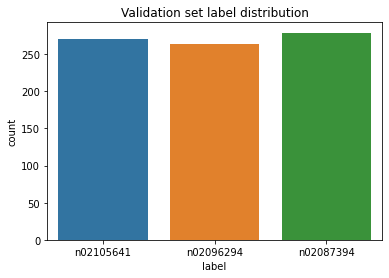

In [23]:
sns.countplot(data=df_val, x='label')
plt.title('Validation set label distribution') 
plt.show()

## Encoding

In [24]:
def one_hot_encode(y, num_classes):
  le = LabelEncoder()
  return to_categorical(le.fit_transform(y), num_classes)

In [25]:
y_train[0]

'n02096294'

In [26]:
y_train = one_hot_encode(y_train, NUM_CLASSES)

In [27]:
y_train[0]

array([0., 1., 0.], dtype=float32)

In [28]:
y_test[0]

'n02087394'

In [29]:
y_test = one_hot_encode(y_test, NUM_CLASSES)

In [30]:
y_test[0]

array([1., 0., 0.], dtype=float32)

In [31]:
np.array(y_train).shape

(2835, 3)

In [32]:
y_val[0]

'n02105641'

In [33]:
y_val = one_hot_encode(y_val, NUM_CLASSES)

In [34]:
y_val

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

## Create train, validation and test sets

In [35]:
train_datagen = ImageDataGenerator( 
    rescale=1./255,
    fill_mode="nearest",
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
train_ds = train_datagen.flow(
  np.array(X_train), y_train,
  shuffle=True,
  batch_size=128
)

val_ds = val_datagen.flow(
  np.array(X_val), y_val,
  shuffle=True,
  batch_size=128
)

test_ds = test_datagen.flow(
  np.array(X_test), y_test,
  shuffle=False,
  batch_size=128
)

In [37]:
print('Shape of training samples: ', train_ds.x.shape)
print('Shape of validation samples: ', val_ds.x.shape)
print('Shape of test samples: ', test_ds.x.shape)

Shape of training samples:  (2835, 224, 224, 3)
Shape of validation samples:  (814, 224, 224, 3)
Shape of test samples:  (401, 224, 224, 3)


## Build model

In [73]:
def build_model():
  base_model = ResNet50(include_top=False, weights='imagenet')

  for layer in base_model.layers[:143]: 
    layer.trainable = False

  # add a global spatial average pooling layer
  x = GlobalAveragePooling2D()(base_model.output)

  # add fully-connected
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x) 
  x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
  out = Dense(3, activation='softmax', kernel_regularizer='l2')(x)

  model = Model(base_model.input, out)

  model.compile(
      optimizer=Adam(learning_rate=1e-5),
      loss='categorical_crossentropy',
      metrics=[
          CategoricalAccuracy(),
          Precision(), 
          Recall(),
          AUC()
        ]
  )

  return model

In [74]:
custom_resnet_model = build_model()

In [75]:
custom_resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [76]:
for i, layer in enumerate(custom_resnet_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_2 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

## Train model

### Initialise callbacks

In [77]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/EE544 Computer Vision/Assignment/task-2-weights.hdf5', verbose=1, save_best_only=True, monitor='val_categorical_accuracy')

### Fit the model

In [78]:
resnet_history = custom_resnet_model.fit(
    train_ds,
    epochs=15,
    verbose=1,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 21.5408 - categorical_accuracy: 0.4116 - precision_1: 0.5890 - recall_1: 0.0152 - auc_1: 0.5980
Epoch 1: val_categorical_accuracy improved from -inf to 0.32432, saving model to /content/drive/MyDrive/EE544 Computer Vision/Assignment/task-2-weights.hdf5
23/23 [==============================] - 53s 2s/step - loss: 21.5408 - categorical_accuracy: 0.4116 - precision_1: 0.5890 - recall_1: 0.0152 - auc_1: 0.5980 - val_loss: 21.4689 - val_categorical_accuracy: 0.3243 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.4713
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 21.2614 - categorical_accuracy: 0.5072 - precision_1: 0.7013 - recall_1: 0.0928 - auc_1: 0.6936
Epoch 2: val_categorical_accuracy improved from 0.32432 to 0.32555, saving model to /content/drive/MyDrive/EE544 Computer Vision/Assignment/task-2-weights.hdf5
23/23 [==============================] - 43s 2s/step - loss: 21.26

## Plot the results

In [79]:
def plot(train, validation, ylabel, title):
  plt.plot(train, color='red', label='train') 
  plt.plot(validation, color='blue', label='validation') 
  plt.title(title) 
  plt.ylabel(ylabel)
  plt.xlabel('Epoch')
  plt.legend() 
  plt.grid(linestyle='-', linewidth=0.5)

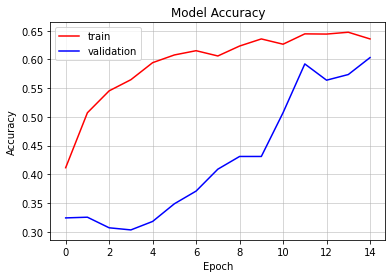

In [80]:
plot(resnet_history.history['categorical_accuracy'], resnet_history.history['val_categorical_accuracy'], 'Accuracy', 'Model Accuracy')

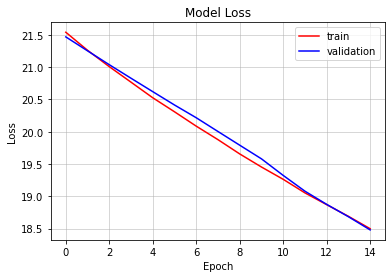

In [81]:
plot(resnet_history.history['loss'], resnet_history.history['val_loss'], 'Loss', 'Model Loss')

## Evaluate model

In [82]:
def evaluate_and_predict(model): 
  # evaluate on test dataset
  eval_results = model.evaluate(test_ds, batch_size=30)

  # print evaluation results
  print('Test loss:', eval_results[0])
  print('Test categorical_accuracy:', eval_results[1])
  print('Test precision:', eval_results[2])
  print('Test recall:', eval_results[3])
  print('Test auc:', eval_results[4])

  # predict
  return model.predict(test_ds)

In [83]:
pred = evaluate_and_predict(custom_resnet_model)

4/4 [==============================] - 1s 285ms/step - loss: 18.4975 - categorical_accuracy: 0.5935 - precision_1: 0.6526 - recall_1: 0.5012 - auc_1: 0.7825
Test loss: 18.497520446777344
Test categorical_accuracy: 0.5935162305831909
Test precision: 0.6525974273681641
Test recall: 0.5012468695640564
Test auc: 0.7825339436531067
4/4 [==============================] - 2s 377ms/step


In [84]:
pred

array([[0.8822613 , 0.06939578, 0.04834305],
       [0.91863537, 0.07048311, 0.01088153],
       [0.6928481 , 0.25621882, 0.05093313],
       ...,
       [0.66829246, 0.11653734, 0.21517019],
       [0.4923104 , 0.45072922, 0.05696039],
       [0.4071742 , 0.33717972, 0.25564614]], dtype=float32)

In [85]:
def draw_confusion_matrix(true, pred):
  cm = confusion_matrix(true.argmax(axis=1), pred.argmax(axis=1))
  sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cbar=False, cmap="viridis")
  plt.show()

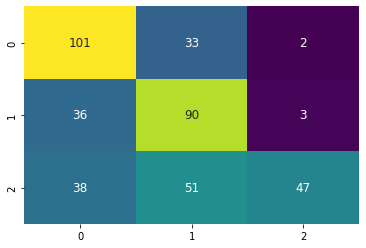

In [86]:
draw_confusion_matrix(y_test, pred)

In [87]:
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       136
           1       0.52      0.70      0.59       129
           2       0.90      0.35      0.50       136

    accuracy                           0.59       401
   macro avg       0.67      0.60      0.58       401
weighted avg       0.67      0.59      0.58       401



## Predict

In [88]:
def predict(model, image):
  pred_image_path = os.path.join(image)
  pred_image = tf.keras.preprocessing.image.load_img(pred_image_path, target_size=(IMG_WIDTH,IMG_HEIGHT))
  pred_image = np.expand_dims(pred_image, axis=0)

  return model.predict(pred_image)

In [89]:
print('Image: Beagle, Prediction', predict(custom_resnet_model, '/content/drive/MyDrive/EE544 Computer Vision/Assignment/task-2-test-images/beagle.JPEG').argmax(axis=1))

1/1 [==============================] - 1s 1s/step
Image: Beagle, Prediction [2]


In [90]:
print('Image: English Foxhound, Prediction', predict(custom_resnet_model, '/content/drive/MyDrive/EE544 Computer Vision/Assignment/task-2-test-images/englishfoxhound.JPEG').argmax(axis=1))

1/1 [==============================] - 0s 30ms/step
Image: English Foxhound, Prediction [0]


In [91]:
print('Image: Shih-Tzu, Prediction', predict(custom_resnet_model, '/content/drive/MyDrive/EE544 Computer Vision/Assignment/task-2-test-images/shihtzu.JPEG').argmax(axis=1))

1/1 [==============================] - 0s 27ms/step
Image: Shih-Tzu, Prediction [2]
